In [50]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from sqlalchemy import create_engine
# Model dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, median_absolute_error
import xgboost as xgb

In [51]:
# Create connection to remote MySQL database
hostname = "gator3228.hostgator.com"
username = "rbrennan_sm_jb"
password = "This_is_not_the_password"
database = "rbrennan_stock_project_4"
# Create a database connection
db_url = f"mysql+mysqlconnector://{username}:{password}@{hostname}/{database}"
engine = create_engine(db_url)
# Test the connection
try:
    conn = engine.connect()
    print("Connected to MySQL database")
except Exception as e:
    print("Error:", e)
nikola_df = pd.read_sql("SELECT * FROM Nikola", conn)

nikola_df#.head()

Exception during reset or similar
Traceback (most recent call last):
  File "c:\Users\justi\anaconda3\envs\dev\lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "c:\Users\justi\anaconda3\envs\dev\lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "c:\Users\justi\anaconda3\envs\dev\lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
  File "c:\Users\justi\anaconda3\envs\dev\lib\site-packages\mysql\connector\connection_cext.py", line 517, in rollback
    self._cmysql.rollback()
_mysql_connector.MySQLInterfaceError: Lost connection to MySQL server during query


Connected to MySQL database


,Date,Open,High,Low,Close,Volume
0,2018-06-12,9.560,9.560,9.560,9.560,300000
1,2018-06-13,9.570,9.580,9.560,9.570,179100
2,2018-06-14,9.570,9.570,9.570,9.570,0
3,2018-06-15,9.570,9.570,9.570,9.570,0
4,2018-06-18,9.540,9.580,9.540,9.580,300
...,...,...,...,...,...,...
1321,2023-09-12,0.889,0.914,0.826,0.912,99803800
1322,2023-09-13,0.910,0.913,0.850,0.870,68874900
1323,2023-09-14,0.871,1.190,0.855,1.150,235670400
1324,2023-09-15,1.330,1.380,1.150,1.190,271454100


In [52]:
# check for missing values in dataset

null_vals = nikola_df.isnull().sum()
null_vals 

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [53]:
# Check all info of dataframe

nikola_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1326 non-null   datetime64[ns]
 1   Open    1326 non-null   float64       
 2   High    1326 non-null   float64       
 3   Low     1326 non-null   float64       
 4   Close   1326 non-null   float64       
 5   Volume  1326 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 62.3 KB


In [54]:
# # Convert date to datetime
# nikola_df['Date'] = pd.to_datetime(nikola_df['Date'])
# # Re-test Data Ty
# nikola_df.dtypes

In [55]:
# Set date column to index

# nikola_df.set_index('Date', inplace=True)


In [56]:
nikola_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [57]:
summary_stats = nikola_df.describe().T
print(summary_stats)

         count          mean           std    min          25%         50%  \
Open    1326.0  1.185430e+01  1.090421e+01  0.557      6.79750       10.04   
High    1326.0  1.224953e+01  1.152684e+01  0.570      7.20625       10.06   
Low     1326.0  1.140478e+01  1.005245e+01  0.521      6.56750        9.99   
Close   1326.0  1.180899e+01  1.079034e+01  0.542      6.79250       10.03   
Volume  1326.0  1.482669e+07  2.949874e+07  0.000  60475.00000  8754650.00   

                 75%           max  
Open    1.189750e+01  9.313000e+01  
High    1.220000e+01  9.399000e+01  
Low     1.133500e+01  7.020000e+01  
Close   1.176750e+01  7.973000e+01  
Volume  1.531118e+07  3.856128e+08  


In [58]:
# calculate 50 day moving average as extra feature
nikola_df['50_day_MA'] = nikola_df['Close'].rolling(window=50).mean()

In [59]:
# Define function to create RSI column (Relative Strength Index), 
# RSI is a momentum oscillator that measures the speed and change of price movements.
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# calculate RSI
nikola_df['RSI'] = calculate_rsi(nikola_df)

In [60]:
nikola_df.head(15)

,Date,Open,High,Low,Close,Volume,50_day_MA,RSI
0,2018-06-12,9.56,9.56,9.56,9.56,300000,NaN,NaN
1,2018-06-13,9.57,9.58,9.56,9.57,179100,NaN,100.000000
2,2018-06-14,9.57,9.57,9.57,9.57,0,NaN,100.000000
3,2018-06-15,9.57,9.57,9.57,9.57,0,NaN,100.000000
4,2018-06-18,9.54,9.58,9.54,9.58,300,NaN,100.000000
5,2018-06-19,9.57,9.57,9.57,9.57,300500,NaN,66.666667
6,2018-06-20,9.54,9.59,9.54,9.59,900,NaN,80.000000
7,2018-06-21,9.59,9.59,9.59,9.59,0,NaN,80.000000
8,2018-06-22,9.58,9.58,9.58,9.58,100,NaN,66.666667
9,2018-06-25,9.58,9.58,9.58,9.58,0,NaN,66.666667


In [61]:
# Define features/targets & Split data for training & testing 

#features
features = ['Open', 'High', 'Low', 'Volume', '50_day_MA', 'RSI']
target = 'Close'

#split data
train_data, test_data = train_test_split(nikola_df, test_size=0.05, shuffle=False)

In [62]:
# # Preprocessing data with StandardScaler

# # Create a StandardScaler instances
# scaler = StandardScaler()

# # Fit the StandardScaler
# train_scaler = scaler.fit(train_data[features])
# # Scale the data
# train_scaled = train_scaler.transform(train_data[features])
# test_scaled = train_scaler.transform(test_data[features])

In [63]:
# train_d = pd.DataFrame(train_scaled, columns=features)
# test_d = pd.DataFrame(test_scaled, columns=features)

In [64]:
# train_d['Date'] = train_data['Date']
# test_d['Date'] = test_data['Date']

In [65]:
# train_data = train_d
# test_data = test_d

In [66]:
train_data.describe()

,Open,High,Low,Close,Volume,50_day_MA,RSI
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1210.000000,1258.000000
mean,12.395979,12.805195,11.929549,12.348381,1.049335e+07,12.639663,50.350466
std,10.927161,11.567437,10.048054,10.809749,1.408345e+07,9.842791,18.249876
min,0.557000,0.570000,0.521000,0.542000,0.000000e+00,0.843880,0.000000
25%,7.885000,8.180000,7.665000,7.955000,4.570000e+04,8.381800,36.335266
50%,10.100000,10.150000,10.040000,10.100000,8.403600e+06,10.161640,51.733746
75%,12.340000,12.708000,11.817500,12.115000,1.401855e+07,13.130775,62.500000
max,93.129997,93.989998,70.199997,79.730003,1.385377e+08,51.660080,100.000000


 ## ARIMA model 

In [67]:
# Define ARIMA model 
arima_model = ARIMA(train_data[target], order=(1, 1, 2))
arima_fit = arima_model.fit()

In [68]:
predictions = arima_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data[target], predictions)
print(mse)

1.24450728536255


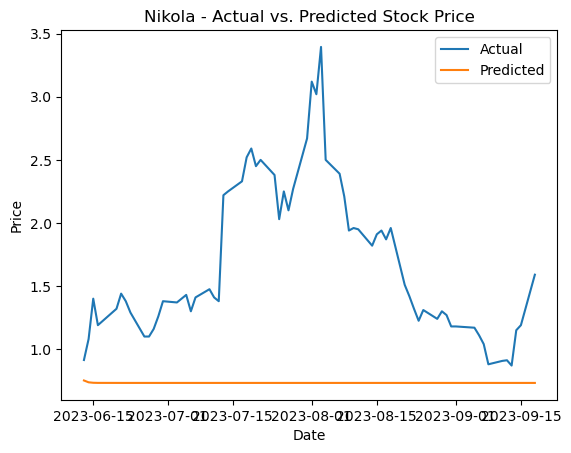

In [69]:
# plot ARIMA model 
plt.plot(test_data['Date'], test_data[target], label='Actual')
plt.plot(test_data['Date'], predictions, label='Predicted')
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Nikola - Actual vs. Predicted Stock Price')
plt.show()

## XGBoost Model

In [70]:
# Define XGBoost Model

#features & target
features_xgb = ['Open', 'High', 'Low', 'Volume', '50_day_MA', 'RSI']
target_xgb = 'Close'

train_dmatrix = xgb.DMatrix(data=train_data[features_xgb], label=train_data[target_xgb])

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 30,
    'learning_rate': 0.3
}

# Train the XGBoost model
xgb_model = xgb.train(params=params, dtrain=train_dmatrix)

## Model Optimization Changes
1. max depth increase from 3 to 10 then to 30
2. learning rate increased to 0.01 reducing accuracy
3. l-rate lowered to 0.3  producing the most acc prediction yet
4. Mistakenly left target in features, removed 'Close' from Features

In [71]:
# Create DMatrix for test data
test_dmatrix = xgb.DMatrix(data=test_data[features_xgb], label=test_data[target_xgb])

# Use the trained XGBoost model to make predictions
xgb_predictions = xgb_model.predict(test_dmatrix)

# Calculate Mean Squared Error
mse_xgb = mean_squared_error(test_data[target_xgb], xgb_predictions)
print(f'Mean Squared Error of XGBoost model : {mse_xgb}')

Mean Squared Error of XGBoost model : 0.04717763970647921


In [72]:
# Calculate mean squared error
mae_xgb = mean_absolute_error(test_data[target_xgb], xgb_predictions)
mae_xgb

0.17154750236112679

In [73]:
test_dmatrix_data = test_dmatrix.get_data()
print(test_data)

           Date   Open   High    Low  Close     Volume  50_day_MA        RSI
1259 2023-06-13  0.800  0.960  0.752  0.914  128579800    0.83796  59.459459
1260 2023-06-14  1.050  1.175  0.990  1.080  121061200    0.83376  67.906977
1261 2023-06-15  1.230  1.830  1.180  1.400  307869000    0.83736  88.367546
1262 2023-06-16  1.700  1.720  1.130  1.190  233099000    0.83776  74.834437
1263 2023-06-20  1.270  1.340  1.180  1.320   71793600    0.83976  76.934750
...         ...    ...    ...    ...    ...        ...        ...        ...
1321 2023-09-12  0.889  0.914  0.826  0.912   99803800    1.82588  20.533643
1322 2023-09-13  0.910  0.913  0.850  0.870   68874900    1.81588  22.014925
1323 2023-09-14  0.871  1.190  0.855  1.150  235670400    1.81028  46.208291
1324 2023-09-15  1.330  1.380  1.150  1.190  271454100    1.80808  43.644068
1325 2023-09-18  1.240  1.630  1.230  1.590  306512500    1.81168  63.736264

[67 rows x 8 columns]


In [74]:
xgb_model.get_score()

{'Open': 252.0,
 'High': 214.0,
 'Low': 207.0,
 'Volume': 149.0,
 '50_day_MA': 99.0,
 'RSI': 96.0}

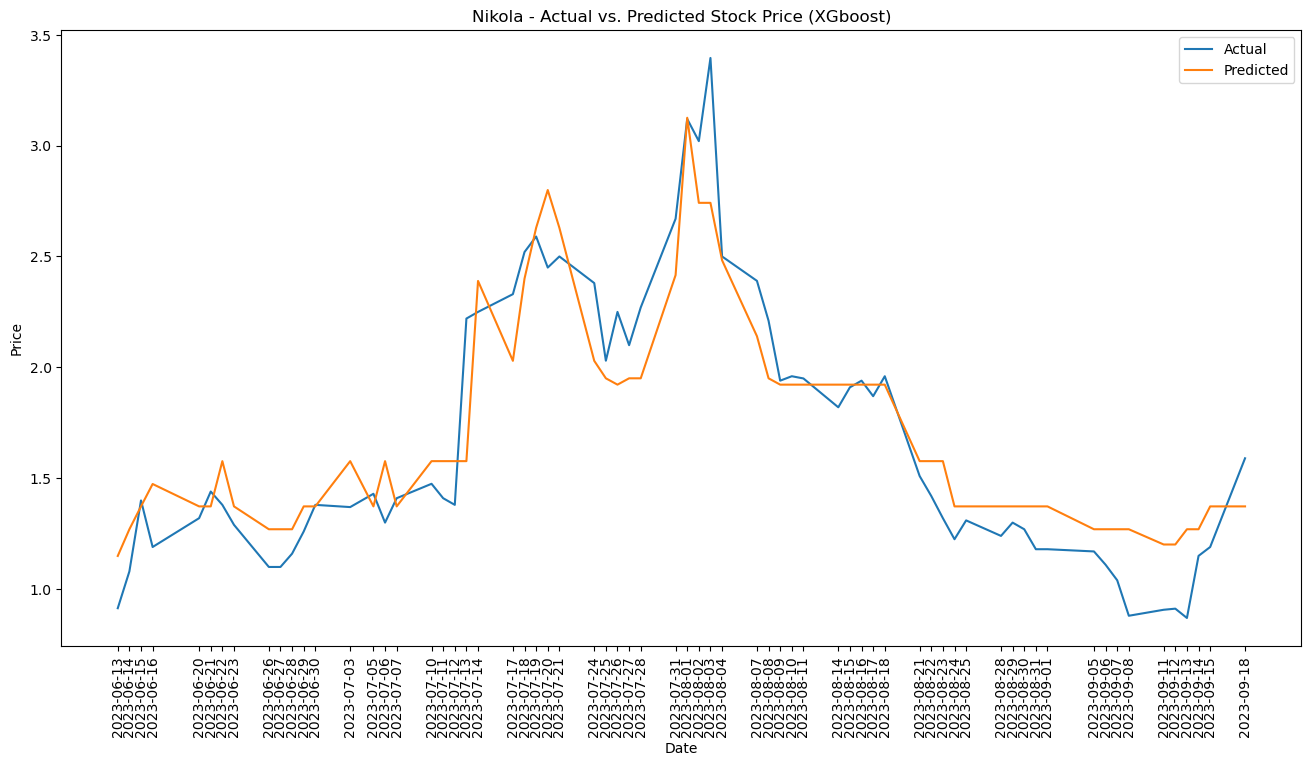

In [75]:
# plot XGBoost model
plt.figure(figsize=(16,8))
plt.plot(test_data['Date'], test_data[target_xgb], label='Actual')
plt.plot(test_data['Date'], xgb_predictions, label='Predicted')
plt.legend(loc='upper right')
plt.xticks(test_data['Date'], rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Nikola - Actual vs. Predicted Stock Price (XGboost)')
plt.show()
